Insatll Requiements

In [ ]:
!pip install yfinance

Preview of Data

[*********************100%***********************]  1 of 1 completed


Price                           Close        High         Low        Open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2024-10-25 13:30:00+00:00  232.130005  232.429901  229.570007  229.740005   
2024-10-25 14:30:00+00:00  232.229996  233.199997  232.119995  232.119995   
2024-10-25 15:30:00+00:00  232.710007  232.731995  231.759995  232.229996   
2024-10-25 16:30:00+00:00  231.857498  232.940002  231.529999  232.735001   
2024-10-25 17:30:00+00:00  231.839996  231.971497  231.070007  231.830002   

Price                       Volume  
Ticker                        AAPL  
Datetime                            
2024-10-25 13:30:00+00:00  8235944  
2024-10-25 14:30:00+00:00  4138746  
2024-10-25 15:30:00+00:00  3211126  
2024-10-25 16:30:00+00:00  2367087  
2024-10-25 17:30:00+00:00  2818009  


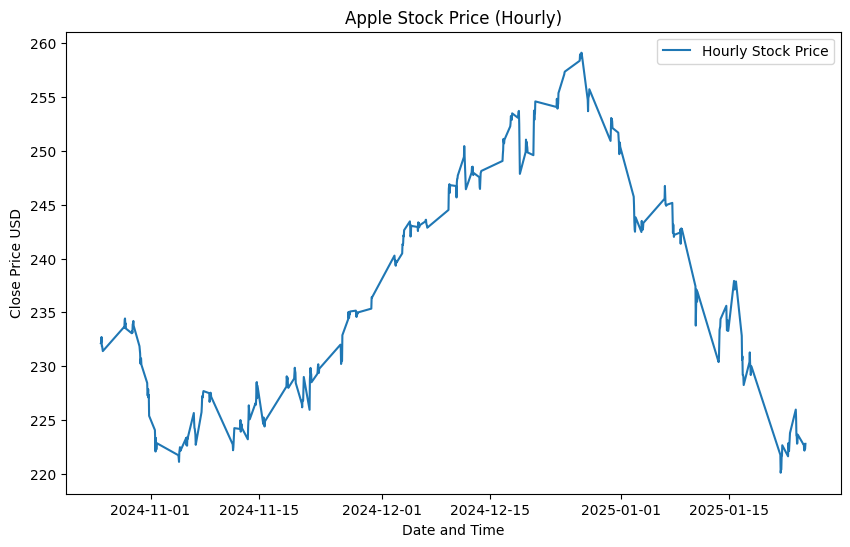

In [36]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch hourly data for AAPL
df = yf.download('AAPL', interval='1h', period='3mo')  # Last 7 days of hourly data

# Display the first few rows
print(df.head())

# Plot the stock price
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Hourly Stock Price')
plt.title('Apple Stock Price (Hourly)')
plt.xlabel('Date and Time')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()


In [37]:
df['Volume']

Ticker,AAPL
Datetime,
2024-10-25 13:30:00+00:00,8235944
2024-10-25 14:30:00+00:00,4138746
2024-10-25 15:30:00+00:00,3211126
2024-10-25 16:30:00+00:00,2367087
2024-10-25 17:30:00+00:00,2818009
...,...
2025-01-24 16:30:00+00:00,3663211
2025-01-24 17:30:00+00:00,2527346
2025-01-24 18:30:00+00:00,2019240


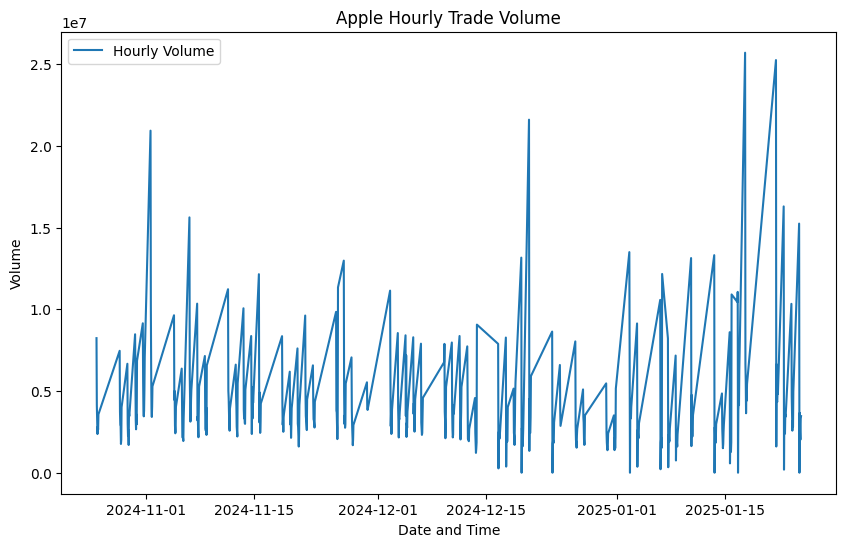

In [38]:
# Plot hourly trade volume
plt.figure(figsize=(10, 6))
plt.plot(df['Volume'], label='Hourly Volume')
plt.title('Apple Hourly Trade Volume')
plt.xlabel('Date and Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

**Data Preparation** --- Using hour as an interval.



In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Fetch hourly data for AAPL
df = yf.download('AAPL', interval='1h', period='3mo')

[*********************100%***********************]  1 of 1 completed


In [56]:
# Ensure the data is complete and clean
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.index = df.index.tz_convert('US/Eastern')
df.dropna(inplace=True)

# Feature engineering: Use Volume and Close price as input features
data = df[['Volume', 'Close']]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [57]:
df['Volume'] # ensure we convert the time correctly

Ticker,AAPL
Datetime,
2024-10-25 09:30:00-04:00,8235944
2024-10-25 10:30:00-04:00,4138746
2024-10-25 11:30:00-04:00,3211126
2024-10-25 12:30:00-04:00,2367087
2024-10-25 13:30:00-04:00,2818009
...,...
2025-01-24 11:30:00-05:00,3663211
2025-01-24 12:30:00-05:00,2527346
2025-01-24 13:30:00-05:00,2019240


In [58]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length, :])
        targets.append(data[i + seq_length, 1])  # Predicting the 'Close' price
    return np.array(sequences), np.array(targets)

In [60]:
seq_length = 24  # Use the last 24 hours for prediction Note: this is not an entire day! But arodun 3 days
X, y = create_sequences(data_scaled, seq_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [63]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # project to the prediction

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only use the last output
        return out

# Model parameters
input_size = 2  # Volume and Close price
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

Training Progress:   9%|▊         | 11/128 [00:02<00:21,  5.34it/s]

Epoch [10/128], Loss: 0.1531


Training Progress:  16%|█▋        | 21/128 [00:04<00:19,  5.60it/s]

Epoch [20/128], Loss: 0.0779


Training Progress:  24%|██▍       | 31/128 [00:05<00:17,  5.56it/s]

Epoch [30/128], Loss: 0.0639


Training Progress:  32%|███▏      | 41/128 [00:07<00:15,  5.53it/s]

Epoch [40/128], Loss: 0.0459


Training Progress:  40%|███▉      | 51/128 [00:09<00:13,  5.66it/s]

Epoch [50/128], Loss: 0.0189


Training Progress:  47%|████▋     | 60/128 [00:11<00:12,  5.31it/s]

Epoch [60/128], Loss: 0.0099


Training Progress:  55%|█████▍    | 70/128 [00:13<00:15,  3.84it/s]

Epoch [70/128], Loss: 0.0064


Training Progress:  63%|██████▎   | 81/128 [00:16<00:08,  5.26it/s]

Epoch [80/128], Loss: 0.0059


Training Progress:  71%|███████   | 91/128 [00:17<00:06,  5.42it/s]

Epoch [90/128], Loss: 0.0050


Training Progress:  79%|███████▉  | 101/128 [00:19<00:04,  5.56it/s]

Epoch [100/128], Loss: 0.0046


Training Progress:  87%|████████▋ | 111/128 [00:21<00:03,  5.55it/s]

Epoch [110/128], Loss: 0.0043


Training Progress:  95%|█████████▍| 121/128 [00:23<00:01,  5.49it/s]

Epoch [120/128], Loss: 0.0041


Training Progress: 100%|██████████| 128/128 [00:24<00:00,  5.19it/s]


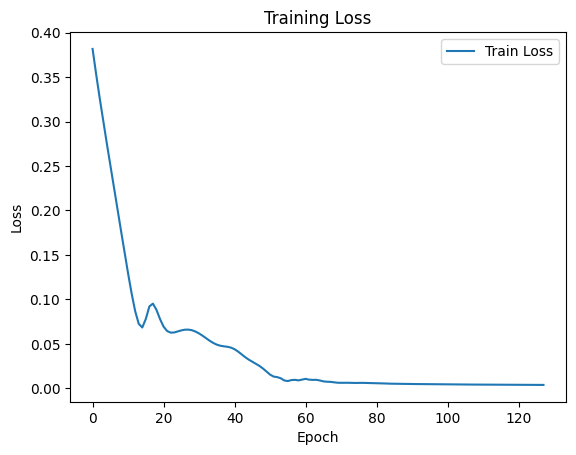

In [64]:
# Loss function and optimizer
import matplotlib.pyplot as plt
from tqdm import tqdm
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 128
train_losses = []

plt.ion()  # Interactive mode for real-time plotting
fig, ax = plt.subplots()
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
line, = ax.plot([], [], label="Train Loss")
ax.legend()

for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Update the plot
    line.set_xdata(range(len(train_losses)))
    line.set_ydata(train_losses)
    ax.relim()  # Recalculate limits
    ax.autoscale_view()  # Adjust axis to new data
    fig.canvas.draw()
    fig.canvas.flush_events()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

plt.ioff()
plt.show()


torch.Size([79, 1]) torch.Size([79, 1])
Test Loss: 0.0034


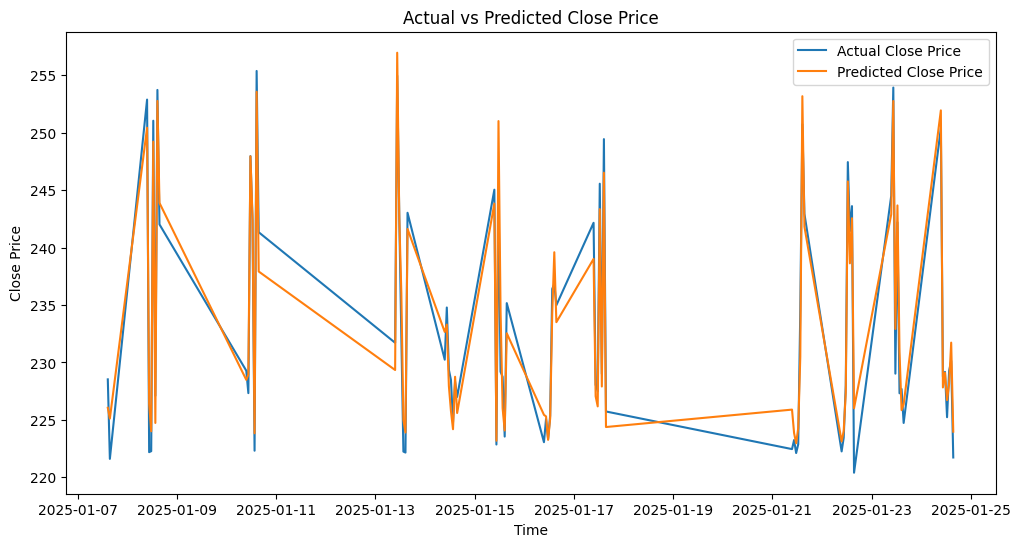

In [65]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)

    # Reshape y_test to match predictions' shape
    y_test = y_test.view(-1, 1)

    # Ensure predictions and y_test have the same shape
    print(predictions.shape, y_test.shape)

    # Calculate the test loss
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions and targets to numpy arrays for inverse scaling
predictions = predictions.numpy()
y_test = y_test.numpy()

# Inverse transform predictions and targets
predictions = scaler.inverse_transform(np.hstack((np.zeros_like(predictions), predictions)))[:, 1]
y_test = scaler.inverse_transform(np.hstack((np.zeros_like(y_test), y_test)))[:, 1]

# Extract the corresponding timestamps for plotting timestamps on the x-axis
timestamps = df.index[-len(y_test):]  # Extract timestamps for the test set

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(timestamps, y_test, label='Actual Close Price')
plt.plot(timestamps, predictions, label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.title('Actual vs Predicted Close Price')
plt.show()


In [66]:
# Show the last prediction specifically
last_timestamp = timestamps[-1]
last_actual = y_test[-1]
last_predicted = predictions[-1]
print(f"Last Timestamp: {last_timestamp}")
print(f"Last Actual Close Price: {last_actual}")
print(f"Last Predicted Close Price: {last_predicted}")

Last Timestamp: 2025-01-24 15:30:00-05:00
Last Actual Close Price: 221.73150634765625
Last Predicted Close Price: 223.9786376953125


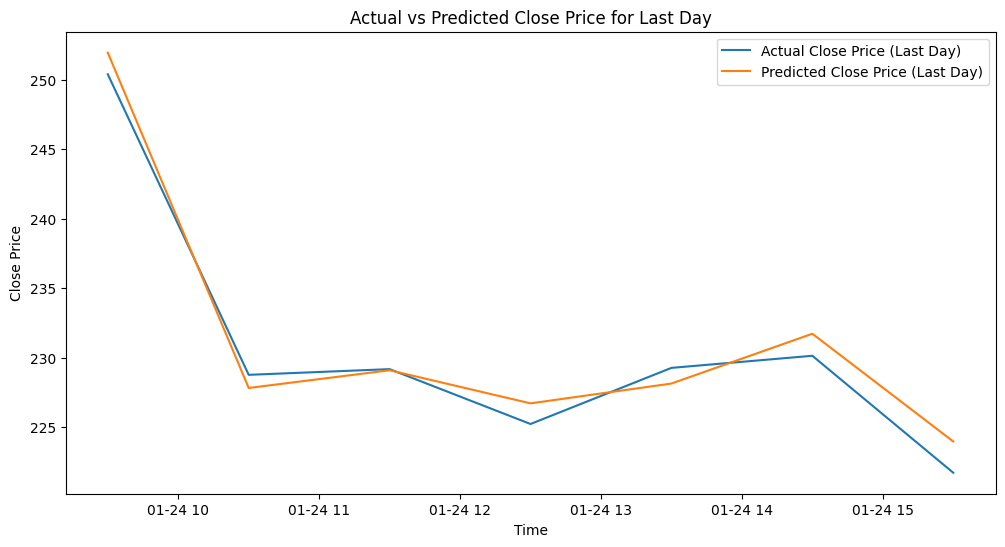

Last Day Predictions:
Timestamp: 2025-01-24 09:30:00-05:00, Actual: 250.38, Predicted: 251.93
Timestamp: 2025-01-24 10:30:00-05:00, Actual: 228.77, Predicted: 227.83
Timestamp: 2025-01-24 11:30:00-05:00, Actual: 229.18, Predicted: 229.10
Timestamp: 2025-01-24 12:30:00-05:00, Actual: 225.24, Predicted: 226.72
Timestamp: 2025-01-24 13:30:00-05:00, Actual: 229.27, Predicted: 228.14
Timestamp: 2025-01-24 14:30:00-05:00, Actual: 230.14, Predicted: 231.72
Timestamp: 2025-01-24 15:30:00-05:00, Actual: 221.73, Predicted: 223.98


In [68]:
# Show the predictions for the last day specifically
last_day_timestamps = timestamps[-7:]
last_day_actuals = y_test[-7:]
last_day_predictions = predictions[-7:]

plt.figure(figsize=(12, 6))
plt.plot(last_day_timestamps, last_day_actuals, label='Actual Close Price (Last Day)')
plt.plot(last_day_timestamps, last_day_predictions, label='Predicted Close Price (Last Day)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.title('Actual vs Predicted Close Price for Last Day')
plt.show()

# Print the last day's data
print("Last Day Predictions:")
for i in range(len(last_day_timestamps)):
    print(f"Timestamp: {last_day_timestamps[i]}, Actual: {last_day_actuals[i]:.2f}, Predicted: {last_day_predictions[i]:.2f}")


**Predicting the Stock Price Tommorow**

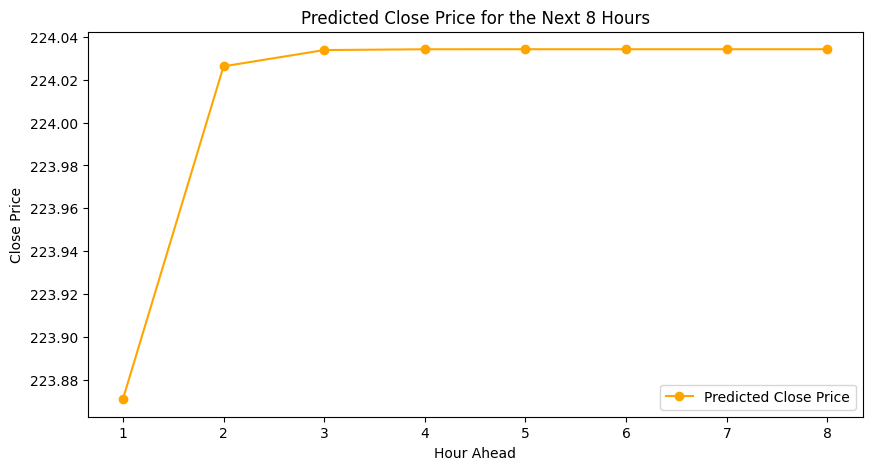

Predicted Close Prices for the Next 8 Hours:
Hour 1: 223.87
Hour 2: 224.03
Hour 3: 224.03
Hour 4: 224.03
Hour 5: 224.03
Hour 6: 224.03
Hour 7: 224.03
Hour 8: 224.03


In [72]:
# Predict the stock price for the next 8 hours
next_8_hours_predictions = []
last_sequence = torch.tensor(data_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0)  # Use the last 24 hours

for _ in range(8):
    with torch.no_grad():
        next_hour_scaled = model(last_sequence).item()

    # Inverse transform to get the actual predicted price
    next_hour_prediction = scaler.inverse_transform([[0, next_hour_scaled]])[0, 1]
    next_8_hours_predictions.append(next_hour_prediction)

    # Update the sequence for the next prediction
    next_sequence_scaled = np.append(data_scaled[-seq_length + 1:], [[0, next_hour_scaled]], axis=0)
    last_sequence = torch.tensor(next_sequence_scaled, dtype=torch.float32).unsqueeze(0)

# Plot the predictions for the next 8 hours
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), next_8_hours_predictions, marker='o', color='orange', label='Predicted Close Price')
plt.xlabel('Hour Ahead')
plt.ylabel('Close Price')
plt.title('Predicted Close Price for the Next 8 Hours')
plt.legend()
plt.show()

print("Predicted Close Prices for the Next 8 Hours:")
for i, price in enumerate(next_8_hours_predictions):
    print(f"Hour {i + 1}: {price:.2f}")
